# MSDS 451: Financial Engineering - Programming Assignment 3

**Eli Freedman**<br>

**November 2, 2025**

## Overview

This assignment investigates employing a mean-reversion and momentum-based trading strategy for the term project's asset portfolio. The portfolio used for the term project is a consumer staples ETF called $SGCS, consisting of five blue-chip equities in the consumer staples market. Additionally, these trading strategies will be back-tested and benchmarked.

## Imports

In [1]:
import time

from datetime import date
from pathlib import Path
from typing import Iterable, List, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow
import yfinance as yf

## Set Variables and Functions

### Tickers + Dates

In [13]:
tickers     = ["PG", "KO", "PEP", "COST", "WMT", "SPY"]

start_date  = "2000-01-01"
end_date    = "2025-01-01"

TRAIN_START = date(2000, 1, 1)
TRAIN_END   = date(2019, 12, 31)
TEST_START  = date(2020, 1, 1)
TEST_END    = date(2024, 12, 31)

### Download Ticker Data

In [3]:
def download_ticker_data(
    tickers: Iterable[str],
    start: str,
    end: str,
    retries: int = 3,
    pause: float = 1.0
) -> List[str]:
    """
    Downloads historical stock data for a list of tickers using yfinance and saves each to a CSV file
    in the same directory as the executing file (or the notebook's directory when in Jupyter).
    """
    dest = Path.cwd()
    saved_files: List[str] = []

    for t in tickers:
        t = str(t).upper().strip()
        out_path = dest / f"{t}.csv"
        attempt = 0

        while attempt < retries:
            try:
                print(f"Downloading data for {t} (attempt {attempt+1}/{retries}) from {start} to {end} ...")
                ticker = yf.Ticker(t)
                historical_data = ticker.history(start=start, end=end)

                if historical_data is None or historical_data.empty:
                    raise ValueError(f"No data returned for {t} (start={start}, end={end})")

                historical_data.to_csv(out_path)
                print(f"Data for {t} saved to {out_path}")
                saved_files.append(str(out_path))
                break

            except Exception as exc:
                attempt += 1
                print(f"Failed to download {t}: {exc}")
                if attempt < retries:
                    print(f"Retrying after {pause} seconds...")
                    time.sleep(pause)
                else:
                    print(f"Giving up on {t} after {retries} attempts.")

    return saved_files


### Load + Align Prices

In [4]:
def _read_price_csv(path: str, ticker: str) -> pl.DataFrame:
    df = pl.read_csv(path, try_parse_dates=True)

    # Normalize Date
    dt = df["Date"].dtype
    if dt == pl.Datetime:
        df = df.with_columns(pl.col("Date").dt.date())
    elif dt != pl.Date:
        # attempt parse if string/object
        df = df.with_columns(pl.col("Date").str.strptime(pl.Date, strict=False))

    return (
        df.select(
            pl.col("Date").cast(pl.Date).alias("Date"),
            pl.col("Close").cast(pl.Float64).alias(ticker),
        )
        .sort("Date")
    )

def load_prices_from_csv_polars(tickers: List[str]) -> pl.DataFrame:
    dfs = [_read_price_csv(saved_tickers[p], t) for p, t in enumerate(tickers)] # type: ignore
    # master calendar
    calendar = pl.concat([df.select("Date") for df in dfs]).unique().sort("Date")
    out = calendar
    for df in dfs:
        out = out.join(df, on="Date", how="left")

    # forward-fill each price column explicitly, then drop rows w/ any remaining nulls
    price_cols = [c for c in out.columns if c != "Date"]
    out = out.with_columns([pl.col(c).forward_fill().alias(c) for c in price_cols])
    out = out.drop_nulls(subset=price_cols)
    return out

### Compute Returns

In [5]:
def compute_returns(pl_prices: pl.DataFrame) -> pl.DataFrame:
    price_cols = [c for c in pl_prices.columns if c != "Date"]
    rets = pl_prices.select(
        "Date",
        *[(pl.col(c).pct_change()).alias(c) for c in price_cols]
    )
    # drop first row (pct_change nulls)
    rets = rets.drop_nulls(subset=price_cols)
    return rets

### Metrics

In [6]:
def _cagr(equity: np.ndarray, periods_per_year=252) -> float:
    if equity.size < 2:
        return 0.0
    total = equity[-1] / equity[0]
    years = equity.size / periods_per_year
    return (total ** (1/years) - 1) if (total > 0 and years > 0) else 0.0

def _sharpe(returns: np.ndarray, periods_per_year=252, rf=0.0) -> float:
    if returns.size == 0:
        return 0.0
    mu = returns.mean()
    sd = returns.std(ddof=0)
    if sd == 0:
        return 0.0
    ann = (mu - rf/periods_per_year) * periods_per_year
    vol = sd * np.sqrt(periods_per_year)
    return ann / vol if vol > 0 else 0.0

def _max_drawdown(equity: np.ndarray) -> Tuple[float, int, int]:
    roll_max = np.maximum.accumulate(equity)
    dd = equity / roll_max - 1.0
    end = int(np.argmin(dd))
    mdd = float(dd[end])
    start = int(np.argmax(equity[: end + 1]))
    return mdd, start, end

### Mean Reversion

In [7]:
def _clip_pos(expr: pl.Expr, eps: float = 1e-9) -> pl.Expr:
    return pl.max_horizontal(pl.lit(eps), expr)

def xsec_mean_reversion_signals(
    rets: pl.DataFrame,
    lookback: int = 5,
    long_short: bool = True,
    quantile: float = 0.4
) -> pl.DataFrame:
    """
    Cross-sectional mean reversion (no rolling_apply, no clip_min usage):
      - Rolling cumret = exp( sum(log(max(1+r, eps))) ) - 1 over 'lookback'
      - Long losers (bottom quantile), short winners (top quantile) if long_short
      - Row L1-normalize weights each day
    """
    assert 0.0 < quantile < 0.5, "quantile should be in (0, 0.5)"
    asset_cols = [c for c in rets.columns if c != "Date"]

    # Rolling cumulative return via log-sum trick with version-proof clamp
    roll = rets.select(
        "Date",
        *[
            (
                _clip_pos(1.0 + pl.col(c))     # >= eps
                .log()
                .rolling_sum(window_size=lookback, min_samples=lookback)
                .exp() - 1.0
            ).alias(c)
            for c in asset_cols
        ]
    ).drop_nulls(subset=asset_cols)

    # Cross-sectional ranks -> signals
    X = roll.select(asset_cols).to_numpy()
    n_assets = X.shape[1]

    # ranks: ascending (losers first)
    order = np.argsort(X, axis=1)
    ranks = np.empty_like(order)
    rows = np.arange(order.shape[0])[:, None]
    ranks[rows, order] = np.arange(n_assets)[None, :] + 1

    q_low = int(np.floor(quantile * n_assets))
    q_high = n_assets - q_low + 1

    sig = np.zeros_like(X, dtype=float)
    if q_low > 0:
        sig[ranks <= q_low] = 1.0
        if long_short:
            sig[ranks >= q_high] = -1.0

    # L1 row-normalize
    denom = np.sum(np.abs(sig), axis=1, keepdims=True)
    denom[denom == 0] = 1.0
    sig /= denom

    sig_df = pl.DataFrame(sig, schema=asset_cols)
    out = pl.concat([roll.select("Date"), sig_df], how="horizontal")
    return out

### Momentum

In [8]:
def ts_momentum_signals(
    prices: pl.DataFrame,
    lookback: int = 126,
    long_short: bool = True,
    neutral_band: float = 0.0
) -> pl.DataFrame:
    """
    Time-series momentum per asset (no Python UDFs):
      - Signal = sign(price / SMA(lookback) - 1)
      - If long_short=False: long-only with neutral band
      - Row-normalize weights each day
    """
    asset_cols = [c for c in prices.columns if c != "Date"]

    # Simple moving average with alignment
    ma = prices.select(
        "Date",
        *[(pl.col(c).rolling_mean(window_size=lookback, min_samples=lookback)).alias(c) for c in asset_cols]
    ).drop_nulls(subset=asset_cols)

    # Align to dates where MA is defined
    px = prices.join(ma.select("Date"), on="Date", how="inner")
    mom = (
        px.join(ma, on="Date", how="inner", suffix="_MA")
          .select(
              "Date",
              *[((pl.col(c) / pl.col(f"{c}_MA")) - 1.0).alias(c) for c in asset_cols]
          )
    )

    if long_short:
        # sign(x) without UDF: 1 if >0, -1 if <0, 0 otherwise
        sig = mom.select(
            "Date",
            *[
                ((pl.col(c) > 0).cast(pl.Int8) - (pl.col(c) < 0).cast(pl.Int8))
                .cast(pl.Float64)
                .alias(c)
                for c in asset_cols
            ]
        )
    else:
        sig = mom.select(
            "Date",
            *[((pl.col(c) > neutral_band).cast(pl.Float64)).alias(c) for c in asset_cols]
        )

    # Row-normalize (equal weight among non-zero positions)
    sig_np = sig.select(asset_cols).to_numpy()
    denom = np.sum(np.abs(sig_np), axis=1, keepdims=True)
    denom[denom == 0] = 1.0
    sig_np = sig_np / denom
    sig_df = pl.DataFrame(sig_np, schema=asset_cols)
    out = pl.concat([sig.select("Date"), sig_df], how="horizontal")
    return out

### Validation

In [9]:
def backtest(
    prices: pl.DataFrame,
    signals: pl.DataFrame,
    trans_cost_bps: float = 0.0,
    slippage_bps: float = 0.0,
) -> Tuple[pl.DataFrame, pl.DataFrame, pl.DataFrame]:
    """
    Daily rebalanced backtest in Polars.
    Returns: (port_ret: DataFrame[Date, ret], equity: DataFrame[Date, equity], realized_weights: DataFrame)
    """
    assets = [c for c in prices.columns if c != "Date"]
    rets = compute_returns(prices)
    # Align signals to returns dates
    w = signals.join(rets.select("Date"), on="Date", how="inner").sort("Date")

    # Turnover = sum(|w_t - w_{t-1}|)/2 across assets
    diff_cols = [(pl.col(c) - pl.col(c).shift(1)).abs().alias(c) for c in assets]
    turnover = (
        w.select("Date", *diff_cols)
         .with_columns(pl.sum_horizontal(*(pl.col(c) for c in assets)).alias("turn_raw"))
         .select("Date", (pl.col("turn_raw") / 2.0).alias("turnover"))
         .with_columns(pl.col("turnover").fill_null(0.0))
    )

    total_bps = (trans_cost_bps + slippage_bps) / 1e4
    cost = turnover.with_columns((pl.col("turnover") * total_bps).alias("cost")).select("Date", "cost")

    # Portfolio return = sum_i w_{t-1,i} * r_{t,i}
    w_shift = w.select("Date", *[(pl.col(c).shift(1)).alias(c) for c in assets])
    wr = (
        w_shift.join(rets, on="Date", how="inner", suffix="_r")
              .select(
                  "Date",
                  *[(pl.col(a) * pl.col(a + "_r")).alias(a) for a in assets]
              )
              .with_columns(pl.sum_horizontal(*(pl.col(a) for a in assets)).alias("gross_ret"))
              .select("Date", "gross_ret")
    )

    net = wr.join(cost, on="Date", how="left").with_columns(pl.col("cost").fill_null(0.0))
    port_ret = net.select("Date", (pl.col("gross_ret") - pl.col("cost")).alias("ret"))

    equity = port_ret.with_columns((1.0 + pl.col("ret")).cum_prod().alias("equity")).select("Date", "equity")
    return port_ret, equity, w

def performance_report(
    port_ret: pl.DataFrame,
    equity: pl.DataFrame,
    weights: pl.DataFrame
) -> Dict[str, float]:
    ret_np = port_ret["ret"].to_numpy()
    eq_np = equity["equity"].to_numpy()
    cagr = _cagr(eq_np)
    sharpe = _sharpe(ret_np)
    vol = float(ret_np.std(ddof=0) * np.sqrt(252))
    mdd, mdd_s, mdd_e = _max_drawdown(eq_np)
    win_rate = float((ret_np > 0).mean())

    # Avg daily turnover
    assets = [c for c in weights.columns if c != "Date"]
    w_np = weights.select(assets).to_numpy()
    delta = np.abs(w_np[1:] - w_np[:-1]).sum(axis=1) / 2.0
    avg_turnover = float(delta.mean()) if delta.size else 0.0

    d0 = str(equity["Date"][0])
    d1 = str(equity["Date"][-1])
    return {
        "CAGR": cagr,
        "Sharpe": sharpe,
        "Volatility": vol,
        "Max Drawdown": mdd,
        "Win Rate": win_rate,
        "Avg Daily Turnover": avg_turnover,
        "MDD Start Index": mdd_s,
        "MDD End Index": mdd_e,
        "Start": d0,
        "End": d1,
        "Days": int(len(eq_np)),
    }

In [27]:
def equity_perf(df: pl.DataFrame, col: str) -> dict:
    eq = df.select("Date", pl.col(col).alias("E"))
    ret = eq.select("Date", (pl.col("E") / pl.col("E").shift(1) - 1.0).alias("ret")).drop_nulls(subset=["ret"])
    pr_df = ret.select("Date", pl.col("ret").alias("ret"))
    eq_df = eq.select("Date", pl.col("E").alias("equity"))
    perf = performance_report(pr_df, eq_df, eq_df)  # weights not used inside
    return {"Series": col, "CAGR": perf["CAGR"], "Sharpe": perf["Sharpe"], "Vol": perf["Volatility"], "MaxDD": perf["Max Drawdown"], "EndValue": float(eq["E"][-1])}

### Evaluators

In [18]:
def eval_mr(prices, rets, lb, ls, q, cbps):
    sig = xsec_mean_reversion_signals(rets=rets, lookback=lb, long_short=ls, quantile=q)
    pr, eq, w = backtest(prices, sig, trans_cost_bps=cbps)
    perf = performance_report(pr, eq, w)
    row = {
        "Strategy": "MR",
        "MR_lookback": lb, "MR_quantile": float(q), "MR_long_short": bool(ls),
        "MOM_lookback": None, "MOM_long_short": None, "MOM_neutral_band": None,
        "trans_cost_bps": float(cbps),
    }
    row.update(perf)
    return row

def eval_mom(prices, lb, ls, nb, cbps):
    sig = ts_momentum_signals(prices=prices, lookback=lb, long_short=ls, neutral_band=float(nb))
    pr, eq, w = backtest(prices, sig, trans_cost_bps=cbps)
    perf = performance_report(pr, eq, w)
    row = {
        "Strategy": "MOM",
        "MR_lookback": None, "MR_quantile": None, "MR_long_short": None,
        "MOM_lookback": lb, "MOM_long_short": bool(ls), "MOM_neutral_band": float(nb),
        "trans_cost_bps": float(cbps),
    }
    row.update(perf)
    return row

In [23]:
def run_config_on(prices_df, rets_df, row_dict):
    strat = row_dict["Strategy"]
    cbps  = float(row_dict.get("trans_cost_bps", 0) or 0.0)
    if strat == "MR":
        sig = xsec_mean_reversion_signals(
            rets=rets_df,
            lookback=int(row_dict["MR_lookback"]),
            long_short=bool(row_dict["MR_long_short"]),
            quantile=float(row_dict["MR_quantile"]),
        )
    else:
        sig = ts_momentum_signals(
            prices=prices_df,
            lookback=int(row_dict["MOM_lookback"]),
            long_short=bool(row_dict["MOM_long_short"]),
            neutral_band=float(row_dict.get("MOM_neutral_band", 0.0) or 0.0),
        )
    pr, eq, w = backtest(prices_df, sig, trans_cost_bps=cbps)
    return pr, eq, w

## Data Ingestion

In [10]:
saved_tickers = download_ticker_data(tickers, start_date, end_date)
print(saved_tickers)

Data for PG saved to c:\Users\elibf\Documents\Repositories\MSDS-451-PA3\PG.csv
Data for KO saved to c:\Users\elibf\Documents\Repositories\MSDS-451-PA3\KO.csv
Data for PEP saved to c:\Users\elibf\Documents\Repositories\MSDS-451-PA3\PEP.csv
Data for COST saved to c:\Users\elibf\Documents\Repositories\MSDS-451-PA3\COST.csv
Data for WMT saved to c:\Users\elibf\Documents\Repositories\MSDS-451-PA3\WMT.csv
Data for SPY saved to c:\Users\elibf\Documents\Repositories\MSDS-451-PA3\SPY.csv
['c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-PA3\\PG.csv', 'c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-PA3\\KO.csv', 'c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-PA3\\PEP.csv', 'c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-PA3\\COST.csv', 'c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-PA3\\WMT.csv', 'c:\\Users\\elibf\\Documents\\Repositories\\MSDS-451-PA3\\SPY.csv']


In [11]:
prices_pl = load_prices_from_csv_polars(tickers)

## Modeling

### Train-Test Split

In [14]:
prices_train = prices_pl.filter((pl.col("Date") >= pl.lit(TRAIN_START)) & (pl.col("Date") <= pl.lit(TRAIN_END)))
prices_test  = prices_pl.filter((pl.col("Date") >= pl.lit(TEST_START)) & (pl.col("Date") <= pl.lit(TEST_END)))

### Default Mean Reversion Strategy

In [15]:
rets_pl = compute_returns(prices_pl)
mr_signals_pl = xsec_mean_reversion_signals(
    rets=rets_pl,
    lookback=5,
    long_short=False,
    quantile=0.4 # % of assets to long and short; only longs if not taking shorts
)
mr_ret_pl, mr_eq_pl, mr_w_pl = backtest(prices_pl, mr_signals_pl, trans_cost_bps=0)
mr_perf = performance_report(mr_ret_pl, mr_eq_pl, mr_w_pl)

### Default Momentum Strategy

In [16]:
mom_signals_pl = ts_momentum_signals(
    prices=prices_pl,
    lookback=126,
    long_short=False,
    neutral_band=0.002 # the band around the mean; ignored if taking shorts
)
mom_ret_pl, mom_eq_pl, mom_w_pl = backtest(prices_pl, mom_signals_pl, trans_cost_bps=0)
mom_perf = performance_report(mom_ret_pl, mom_eq_pl, mom_w_pl)


### Default Results

In [17]:
print("Cross-Sectional Mean Reversion")
for k, v in mr_perf.items():
    print(f"{k:>20}: {v:.6f}" if isinstance(v, float) else f"{k:>20}: {v}")

print("\nTime-Series Momentum")
for k, v in mom_perf.items():
    print(f"{k:>20}: {v:.6f}" if isinstance(v, float) else f"{k:>20}: {v}")

Cross-Sectional Mean Reversion
                CAGR: 0.135644
              Sharpe: 0.745280
          Volatility: 0.196782
        Max Drawdown: -0.357044
            Win Rate: 0.532304
  Avg Daily Turnover: 0.304313
     MDD Start Index: 0
       MDD End Index: 42
               Start: 2000-01-10
                 End: 2024-12-31
                Days: 6284

Time-Series Momentum
                CAGR: 0.047137
              Sharpe: 0.393028
          Volatility: 0.143466
        Max Drawdown: -0.567139
            Win Rate: 0.511032
  Avg Daily Turnover: 0.072473
     MDD Start Index: 84
       MDD End Index: 642
               Start: 2000-06-30
                 End: 2024-12-31
                Days: 6164


### Hyperparameter Tuning

In [19]:
rets_train = compute_returns(prices_train)
rets_test  = compute_returns(prices_test)

# Parameters
MR_LOOKBACKS = [3, 5, 10]
MR_QUANTILES = [0.2, 0.4]
MR_LONG_SHORT = [False, True]
MR_COST_BPS   = [0, 5, 10]

MOM_LOOKBACKS    = [63, 126, 252]
MOM_LONG_SHORT   = [False, True]
MOM_NEUTRAL_BAND = [0.0, 0.002, 0.005]   # only used if long_short=False
MOM_COST_BPS     = [0, 5, 10]

OBJECTIVE = "Sharpe"  # or "CAGR"

In [21]:
train_results = []

# Mean reversion
for lb in MR_LOOKBACKS:
    for q in MR_QUANTILES:
        for ls in MR_LONG_SHORT:
            for cbps in MR_COST_BPS:
                try:
                    train_results.append(eval_mr(prices_train, rets_train, lb, ls, q, cbps))
                except Exception as e:
                    train_results.append({
                        "Strategy": "MR",
                        "MR_lookback": lb, "MR_quantile": q, "MR_long_short": ls,
                        "MOM_lookback": None, "MOM_long_short": None, "MOM_neutral_band": None,
                        "trans_cost_bps": float(cbps),
                        "ERROR": str(e),
                        "CAGR": None, "Sharpe": None, "Volatility": None,
                        "Max Drawdown": None, "Win Rate": None, "Avg Daily Turnover": None,
                        "MDD Start Index": None, "MDD End Index": None,
                        "Start": None, "End": None, "Days": None,
                    })

# Momentum
for lb in MOM_LOOKBACKS:
    for ls in MOM_LONG_SHORT:
        nbands = MOM_NEUTRAL_BAND if not ls else [0.0]  # ignore band if long_short=True
        for nb in nbands:
            for cbps in MOM_COST_BPS:
                try:
                    train_results.append(eval_mom(prices_train, lb, ls, nb, cbps))
                except Exception as e:
                    train_results.append({
                        "Strategy": "MOM",
                        "MR_lookback": None, "MR_quantile": None, "MR_long_short": None,
                        "MOM_lookback": lb, "MOM_long_short": ls, "MOM_neutral_band": float(nb),
                        "trans_cost_bps": float(cbps),
                        "ERROR": str(e),
                        "CAGR": None, "Sharpe": None, "Volatility": None,
                        "Max Drawdown": None, "Win Rate": None, "Avg Daily Turnover": None,
                        "MDD Start Index": None, "MDD End Index": None,
                        "Start": None, "End": None, "Days": None,
                    })

train_df = pl.DataFrame(train_results)
train_df.write_csv(Path.cwd() / "train_tuning_results.csv")

In [22]:
# Top-5
top5_train = (
    train_df
    .filter(pl.col(OBJECTIVE).is_not_null())
    .sort(OBJECTIVE, descending=True)
    .head(5)
)

param_cols = [
    "Strategy",
    "MR_lookback", "MR_quantile", "MR_long_short",
    "MOM_lookback", "MOM_long_short", "MOM_neutral_band",
    "trans_cost_bps",
    "Sharpe", "CAGR", "Volatility", "Max Drawdown", "Win Rate",
    "Avg Daily Turnover", "Start", "End", "Days",
]
top5_params = top5_train.select([c for c in param_cols if c in top5_train.columns])
top5_params.write_csv(Path.cwd() / "train_top5_params.csv")

In [24]:
eq_list = []
labels  = []
for i, row in enumerate(top5_params.to_dicts(), start=1):
    label = (
        f"{row['Strategy']}"
        f"_lb{row.get('MR_lookback') or row.get('MOM_lookback')}"
        f"{'_q'+str(row['MR_quantile']) if row['Strategy']=='MR' else ''}"
        f"{'_LS' if (row.get('MR_long_short') if row['Strategy']=='MR' else row['MOM_long_short']) else '_LO'}"
        f"_c{int(row['trans_cost_bps'])}"
    )
    _, eq, _ = run_config_on(prices_test, rets_test, row)
    eq_list.append(eq.rename({"equity": label}))
    labels.append(label)

### Validation

In [26]:
BENCH = "SPY"
spy_prices = _read_price_csv(saved_tickers[5], BENCH)
spy_test = spy_prices.filter((pl.col("Date") >= TEST_START) & (pl.col("Date") <= TEST_END))
spy_rets = spy_test.select("Date", (pl.col(BENCH).pct_change()).alias("ret")).drop_nulls(subset=["ret"])
spy_eq   = spy_rets.select("Date", ((1.0 + pl.col("ret")).cum_prod()).alias(f"{BENCH}_Equity"))

# Join all on common test dates, then normalize each to 1.0 at first common date
joined = spy_eq
for eq in eq_list:
    joined = joined.join(eq, on="Date", how="inner")

eq_cols = [c for c in joined.columns if c != "Date"]
first_vals = joined.select(eq_cols).row(0)
scalers = {c: (first_vals[i] if first_vals[i] not in (0, None) else 1.0) for i, c in enumerate(eq_cols)}
joined = joined.with_columns([(pl.col(c) / scalers[c]).alias(c) for c in eq_cols])
joined.write_csv(Path.cwd() / "test_top5_vs_spy_equity.csv")

In [29]:
summary_rows = [equity_perf(joined, f"{BENCH}_Equity")]
for lbl in labels:
    summary_rows.append(equity_perf(joined, lbl))
summary_df = pl.DataFrame(summary_rows).sort("Sharpe", descending=True)
summary_df.write_csv(Path.cwd() / "test_top5_vs_spy_summary.csv")

print("\n=== Test Summary (Top-5 vs SPY) ===")
print(summary_df)


=== Test Summary (Top-5 vs SPY) ===
shape: (6, 6)
┌────────────────────┬───────────┬───────────┬──────────┬───────────┬──────────┐
│ Series             ┆ CAGR      ┆ Sharpe    ┆ Vol      ┆ MaxDD     ┆ EndValue │
│ ---                ┆ ---       ┆ ---       ┆ ---      ┆ ---       ┆ ---      │
│ str                ┆ f64       ┆ f64       ┆ f64      ┆ f64       ┆ f64      │
╞════════════════════╪═══════════╪═══════════╪══════════╪═══════════╪══════════╡
│ MR_lb10_q0.4_LO_c0 ┆ 0.160524  ┆ 0.817688  ┆ 0.209098 ┆ -0.286524 ┆ 2.090221 │
│ SPY_Equity         ┆ 0.139619  ┆ 0.727105  ┆ 0.210601 ┆ -0.337173 ┆ 1.910275 │
│ MR_lb3_q0.4_LO_c0  ┆ 0.107665  ┆ 0.593472  ┆ 0.209509 ┆ -0.249372 ┆ 1.659309 │
│ MR_lb10_q0.4_LS_c0 ┆ -0.00075  ┆ 0.033382  ┆ 0.084637 ┆ -0.170222 ┆ 0.996289 │
│ MR_lb5_q0.4_LS_c0  ┆ -0.018913 ┆ -0.190862 ┆ 0.082357 ┆ -0.230001 ┆ 0.90977  │
│ MR_lb3_q0.4_LS_c0  ┆ -0.020921 ┆ -0.215563 ┆ 0.082407 ┆ -0.190673 ┆ 0.900589 │
└────────────────────┴───────────┴───────────┴──────────┴─

### Graphs

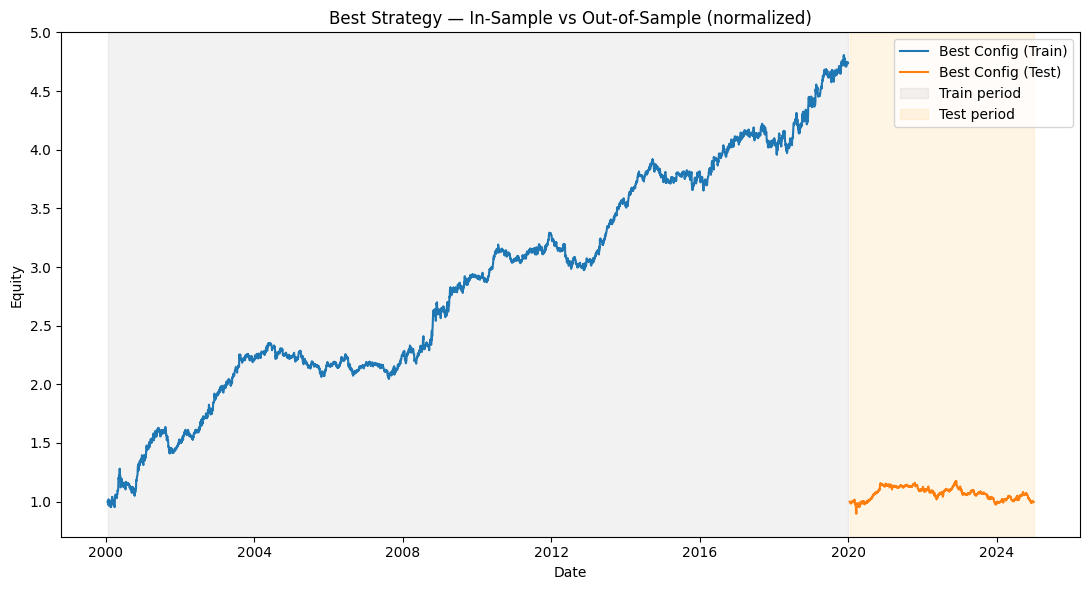

In [34]:
# (a) Best single config: show full curve with train/test shading
best_row = top5_params.sort("Sharpe", descending=True).row(0, named=True)

_, eq_train_best, _ = run_config_on(prices_train, rets_train, best_row)
_, eq_test_best,  _ = run_config_on(prices_test,  rets_test,  best_row)

# Normalize both to 1 at their respective starts, then stitch
eq_train_best = eq_train_best.with_columns((pl.col("equity") / pl.first("equity")).alias("equity"))
eq_test_best = eq_test_best.with_columns((pl.col("equity") / pl.first("equity")).alias("equity"))

plt.figure(figsize=(11, 6))
plt.plot(eq_train_best["Date"].to_pandas(), eq_train_best["equity"].to_pandas(), label="Best Config (Train)")
plt.plot(eq_test_best["Date"].to_pandas(),  eq_test_best["equity"].to_pandas(),  label="Best Config (Test)")
# Shading regions
plt.axvspan(eq_train_best["Date"][0], eq_train_best["Date"][-1], alpha=0.1, color="gray", label="Train period")
plt.axvspan(eq_test_best["Date"][0],  eq_test_best["Date"][-1],  alpha=0.1, color="orange", label="Test period")
plt.title("Best Strategy — In-Sample vs Out-of-Sample (normalized)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.savefig(Path.cwd() / "best_strategy_train_test.png", bbox_inches='tight', dpi=150)
plt.legend(); plt.tight_layout(); plt.show()

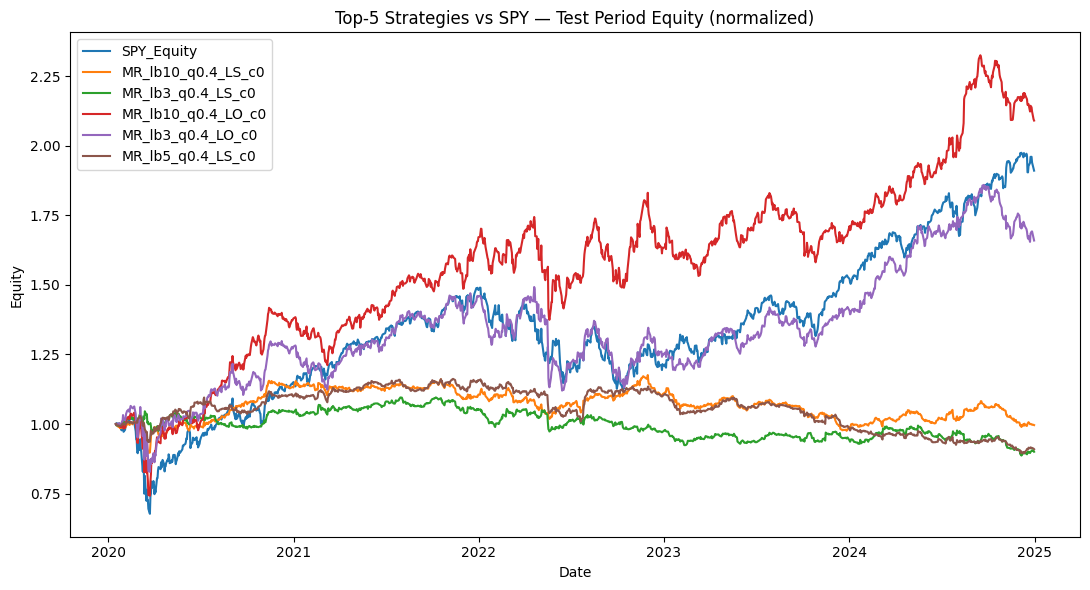

In [35]:
# (b) Test-period equity: Top-5 vs SPY
dates = joined["Date"].to_pandas()
plt.figure(figsize=(11, 6))
for c in [f"{BENCH}_Equity"] + labels:
    plt.plot(dates, joined[c].to_pandas(), label=c)
plt.title("Top-5 Strategies vs SPY — Test Period Equity (normalized)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.savefig(Path.cwd() / "best_strategy_test_normalized.png", bbox_inches='tight', dpi=150)
plt.legend(); plt.tight_layout(); plt.show()

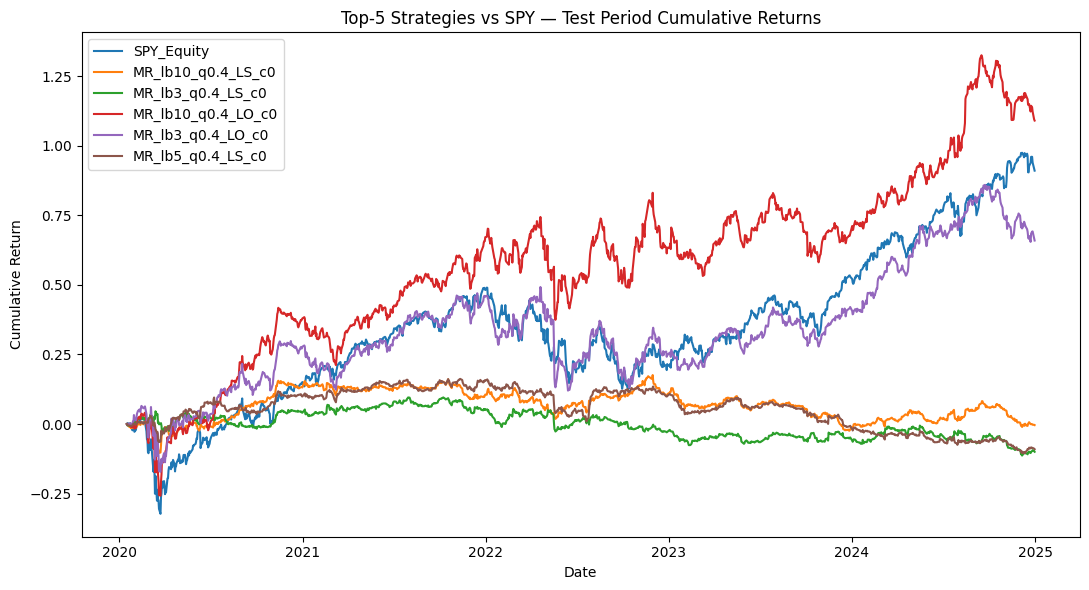

In [36]:
# (c) Test-period cumulative returns: Top-5 vs SPY
cumret = joined.with_columns(*[(pl.col(c) - 1.0).alias(c) for c in [f"{BENCH}_Equity"] + labels])
plt.figure(figsize=(11, 6))
for c in [f"{BENCH}_Equity"] + labels:
    plt.plot(dates, cumret[c].to_pandas(), label=c)
plt.title("Top-5 Strategies vs SPY — Test Period Cumulative Returns")
plt.xlabel("Date"); plt.ylabel("Cumulative Return")
plt.savefig(Path.cwd() / "best_strategy_test_cumulative.png", bbox_inches='tight', dpi=150)
plt.legend(); plt.tight_layout(); plt.show()